In [44]:
import numpy as np
import scipy.signal as signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import re
import os
from numba import jit, prange

from enfify.enf_estimation import segmented_freq_estimation_DFT1, segmented_phase_estimation_hilbert, freq_estimation_DFT1, phase_estimation_DFT1, segmented_phase_estimation_DFT1
from enfify.preprocessing import downsample_ffmpeg, bandpass_filter
from enfify.enf_enhancement import RFA, VMD

In [45]:
@jit(nopython=True, fastmath=True)
def z_SFM(sig, n, sampling_rate, alpha, tau):
    """Computes the z_SFM value with JIT optimization.

    Args:
        sig (numpy.ndarray): Audio signal
        n (int): The index in the signal array at which to compute the z_SFM value
        sampling_rate (float): The sampling frequency of the input signal
        alpha (float): The scaling factor used in the phase calculation
        tau (int): The number of samples to include before and after the index n for summation

    Returns:
        complex: The computed z_SFM value as a complex number, representing the phase shift
    """
    sum_sig = np.sum(sig[n - tau : n + tau + 1])
    z = np.exp(1j * 2 * np.pi * (1 / sampling_rate) * alpha * sum_sig)
    return z


@jit(nopython=True, parallel=True, fastmath=True)
def kernel_function(sig, f, n, sampling_rate, alpha, tau_values, tau_dash_values):
    """Computes the kernel function using JIT and vectorized operations.

    Args:
        sig (numpy.ndarray): Audio signal
        f (float): The frequency at which to evaluate the kernel
        n (int): The index in the signal at which the kernel is computed
        sampling_rate (float): The sampling frequency of the input signal
        alpha (float): The scaling factor used in the kernel calculation
        tau_values (numpy.ndarray): Array of tau values for the first part of the kernel
        tau_dash_values (numpy.ndarray): Array of tau values for the second part of the kernel

    Returns:
        numpy.ndarray: The angles of the computed kernel function values as a complex number array
    """
    auto_corr = np.empty(len(tau_values), dtype=np.complex128)
    auto_corr_dash = np.empty(len(tau_dash_values), dtype=np.complex128)

    for i in range(len(tau_values)):
        auto_corr[i] = z_SFM(sig, n, sampling_rate, alpha, tau_values[i])
        auto_corr_dash[i] = z_SFM(sig, n, sampling_rate, alpha, tau_dash_values[i])

    sin_vals = np.sin(2 * np.pi * (1 / sampling_rate) * f * tau_values)
    cos_vals = np.cos(2 * np.pi * (1 / sampling_rate) * f * tau_values)

    # Precompute exponents to save time in kernel calculation
    kernel = (auto_corr**sin_vals) * (auto_corr_dash**cos_vals)
    return np.angle(kernel)


@jit(nopython=True, parallel=True, fastmath=True)
def rfa_kernel_phases(
    sig, denoised_sig, Nx, f_start, sampling_rate, alpha, tau, tau_values, tau_dash_values
):
    """
    Computes the denoised signal using RFA kernel phases.

    Args:
        sig (numpy.ndarray): Audio Signal
        denoised_sig (numpy.ndarray): Denoised audio signal
        Nx (int): The number of frequency bins
        f_start (numpy.ndarray): The starting frequencies for each bin
        sampling_rate (float): The sampling frequency of the input signal
        alpha (float): The scaling factor for the kernel
        tau (int): The parameter influencing the kernel width
        tau_values (numpy.ndarray): Array of tau values for the kernel computation
        tau_dash_values (numpy.ndarray): Array of tau dash values for the kernel computation

    Returns:
        numpy.ndarray: The computed denoised signal
    """
    for n in prange(Nx - 1):
        f = f_start[n]
        kernel_phases = kernel_function(
            sig, f, n, sampling_rate, alpha, tau_values, tau_dash_values
        )
        denoised_sig[n] = np.sum(kernel_phases) / ((tau + 1) * tau * np.pi * alpha)

    return denoised_sig


def RFA(sig, sampling_rate, tau, epsilon, var_I, estimated_enf):
    """Recursive Frequency Adaptation algorithm with partial JIT optimization.

    Args:
        sig (numpy.ndarray): Audio signal
        sampling_rate (float): The sampling frequency of the input signal
        tau (int): The parameter influencing the kernel widt
        epsilon (float): Convergence threshold for frequency adaptation
        var_I (int): Number of iterations for the adaptation process
        estimated_enf (float): Estimated ENF frequency

    Returns:
        numpy.ndarray: The denoised signal after applying RFA
    """
    Nx = len(sig)
    alpha = 1 / (4 * sampling_rate * np.max(sig))
    f_start = estimated_enf * np.ones(Nx)
    tau_values = np.arange(1, tau + 1)
    tau_dash_values = tau_values + int(np.round(sampling_rate / (4 * estimated_enf)))

    for k in tqdm(range(var_I)):
        denoised_sig = np.zeros(Nx)

        denoised_sig = rfa_kernel_phases(
            sig, denoised_sig, Nx, f_start, sampling_rate, alpha, tau, tau_values, tau_dash_values
        )

        # Peak frequency estimation
        peak_freqs = segmented_freq_estimation_DFT1(
            denoised_sig, sampling_rate, num_cycles=100, N_DFT=20_000, nominal_enf=estimated_enf
        )

        plt.figure(figsize=(10, 4))
        plt.plot(peak_freqs)
        plt.grid()
        plt.show()

        base_repeats = Nx // len(peak_freqs)
        remainder = Nx % len(peak_freqs)
        repeat_counts = np.full(len(peak_freqs), base_repeats)
        repeat_counts[:remainder] += 1
        new_freqs = np.repeat(peak_freqs, repeat_counts)

        f_diff = new_freqs - f_start
        f_start = new_freqs

        val = np.sum(f_diff**2) / np.sum(f_start**2)

        if val <= epsilon:
            return denoised_sig

        sig = denoised_sig  # Update the signal for the next iteration

    return denoised_sig



def segmented_freq_estimation_DFT1(s_in, f_s, num_cycles, N_DFT, nominal_enf):
    """_summary_

    Args:
        s_in (_type_): _description_
        f_s (_type_): _description_
        num_cycles (_type_): _description_
        N_DFT (_type_): _description_
        nominal_enf (_type_): _description_

    Returns:
        _type_: _description_
    """
    step_size = int(f_s // nominal_enf)  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    freqs = []
    for i in range(len(segments)):
        freq = freq_estimation_DFT1(segments[i], f_s, N_DFT)
        freqs.append(freq)

    freqs = np.array(freqs)

    return freqs

def segmented_phase_estimation_DFT1_old(s_in, sampling_rate, nominal_enf, N_DFT, num_cycles):
    """
    Estimates the instantaneous phase of an input signal using DFT1 for segments.

    Args:
        s_in (numpy.ndarray): The input signal for phase estimation
        sampling_rate (float): The sampling rate of the input signal
        nominal_enf (float): The nominal electrical network frequency
        N_DFT (int): The number of points for the DFT
        step_size (int): The number of samples to shift between segments
        window_len (int): The length of each segment to analyze

    Returns:
        numpy.ndarray: An array of estimated phases corresponding to each segment of the input signal.
    """
    segments = []

    step_size = int(sampling_rate // nominal_enf)  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    phases = []
    for segment in segments:
        phase = phase_estimation_DFT1(segment, sampling_rate, N_DFT, nominal_enf)
        phases.append(phase)

    phases = [2 * (x + np.pi / 2) for x in phases]
    phases = np.unwrap(phases)
    phases = [(x / 2.0 - np.pi / 2) for x in phases]

    return phases


In [6]:
noise_fs, down_sig_noise = wavfile.read('/home/leo_dacasi/Dokumente/summerofcode/own_code/ENF-WHU-Dataset/1min_noise/1min_noisy_down/down_min_003.wav')
cut_noise_fs, cut_down_sig_noise = wavfile.read('/home/leo_dacasi/Dokumente/summerofcode/own_code/ENF-WHU-Dataset/1min_noise/1min_noisy_down_cut/down_cut_min_003.wav')
ref_fs, down_sig_ref = wavfile.read('/home/leo_dacasi/Dokumente/summerofcode/own_code/ENF-WHU-Dataset/1min_ref/1min_enf_ref_data/min_003_ref.wav')

n_noise = np.arange(len(down_sig_noise))
n_noise_cut = np.arange(len(cut_down_sig_noise))
n_ref = np.arange(len(down_sig_ref))

print(noise_fs)
print(ref_fs)

1000
400


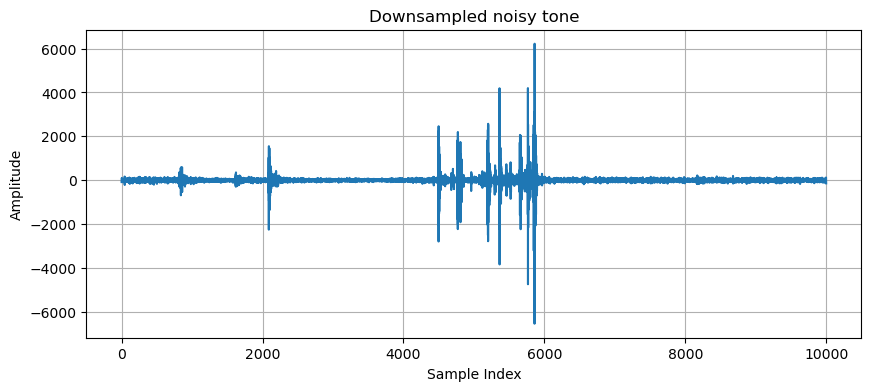

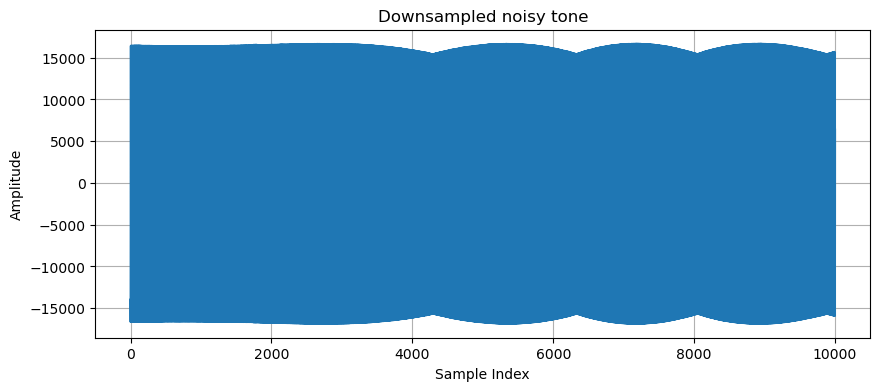

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(n_noise[:10_000], down_sig_noise[:10_000])
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_ref[:10_000], down_sig_ref[:10_000])
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

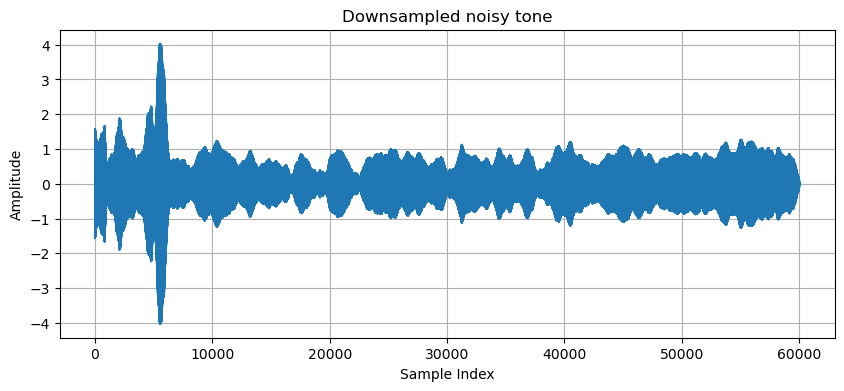

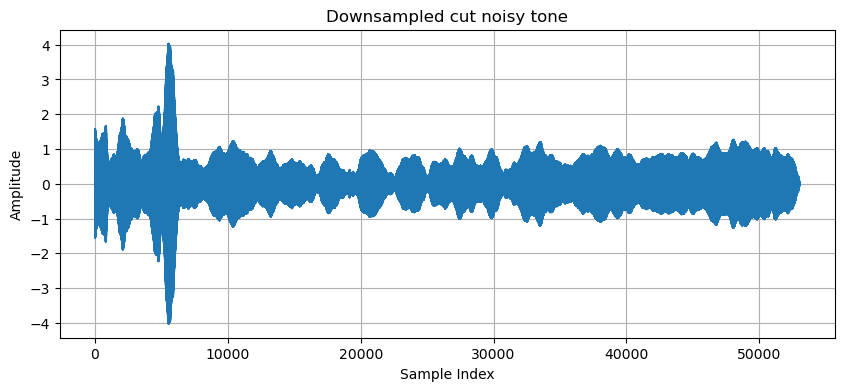

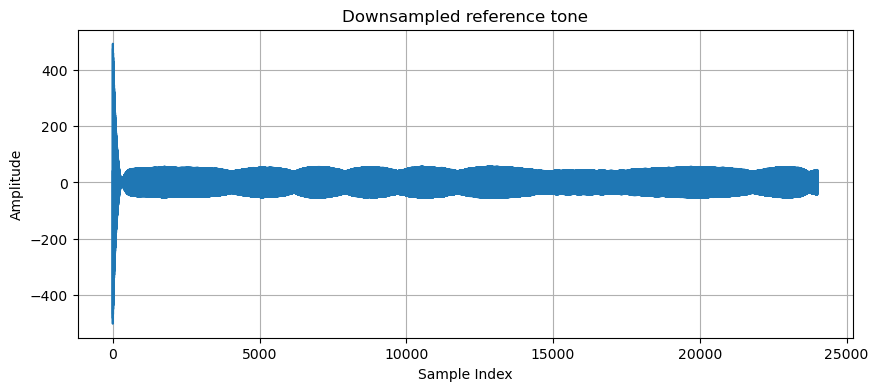

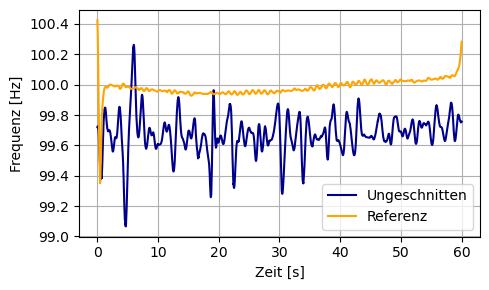

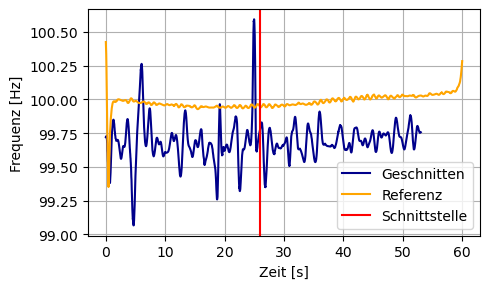

In [9]:
lowcut = 99.5
highcut = 100.5
bandpass_sig = bandpass_filter(down_sig_noise, lowcut, highcut, noise_fs, 1)
bandpass_sig_cut = bandpass_filter(cut_down_sig_noise, lowcut, highcut, noise_fs, 1)
bandpass_ref = bandpass_filter(down_sig_ref, lowcut, highcut, ref_fs, 1)

plt.figure(figsize=(10, 4))
plt.plot(n_noise, bandpass_sig)
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_noise_cut, bandpass_sig_cut)
plt.title('Downsampled cut noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_ref, bandpass_ref)
plt.title('Downsampled reference tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

freqs_DFT1_cut = segmented_freq_estimation_DFT1(bandpass_sig_cut, cut_noise_fs, 100, 20_000, 100)
freqs_DFT1 = segmented_freq_estimation_DFT1(bandpass_sig, noise_fs, 100, 20_000, 100)
freqs_ref = segmented_freq_estimation_DFT1(bandpass_ref, ref_fs, 100, 20_000, 100)

x_cut = len(bandpass_sig_cut)/cut_noise_fs
x = len(bandpass_sig)/noise_fs
x_ref = len(bandpass_ref)/ref_fs
time_cut = np.linspace(0.0, x_cut, len(freqs_DFT1_cut))
time_ref = np.linspace(0.0, x_ref, len(freqs_ref))
time = np.linspace(0.0, x, len(freqs_DFT1))
cut_start = 26

plt.figure(figsize=(5, 3))
plt.plot(time, freqs_DFT1-0.3, color="#00008B", label = "Ungeschnitten")
plt.plot(time_ref, freqs_ref, color="orange", label = "Referenz")
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('whu_authentic_freqs_noisy.pdf', dpi=300)
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(time_cut, freqs_DFT1_cut-0.3, color="#00008B", label = "Geschnitten")
plt.plot(time_ref, freqs_ref, color="orange", label = "Referenz")
plt.axvline(cut_start, color="red", label = "Schnittstelle")
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('whu_tampered_freqs_noisy.pdf', dpi=300)
plt.show()

In [10]:
for i in tqdm(range(1)):    
    alpha =  5000            # Balancing parameter of the data-fidelity constraint
    tau = 0                 # Noise-tolerance (no strict fidelity enforcement)
    n_mode = 1              # Number of modes to be recovered
    DC = 0
    tol =1e-7    # Tolerance of convergence criterion

    u_clean, _, _ = VMD(bandpass_sig, alpha, tau, n_mode, DC, tol)
    bandpass_sig = u_clean[0]

    u_clean_cut, _, _ = VMD(bandpass_sig_cut, alpha, tau, n_mode, DC, tol)
    bandpass_sig_cut = u_clean_cut[0]

    u_clean_ref, _, _ = VMD(bandpass_ref, alpha, tau, n_mode, DC, tol)
    bandpass_ref = u_clean_ref[0]


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


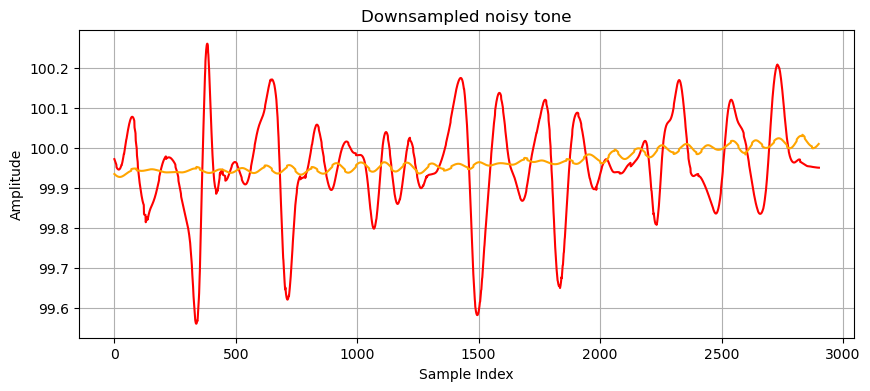

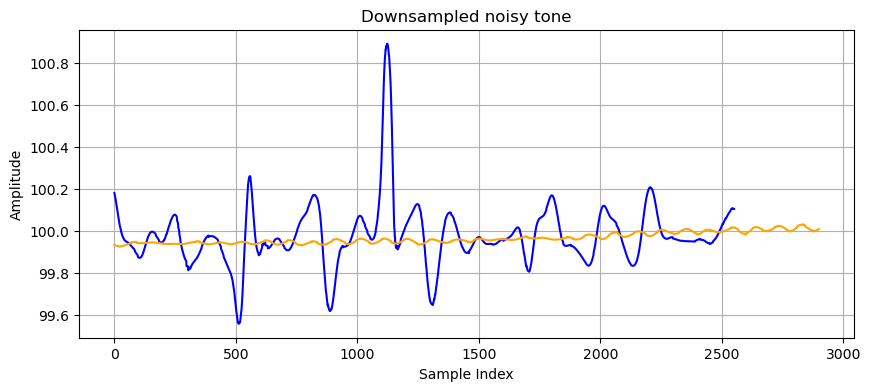

In [11]:
freqs_DFT1_cut = segmented_freq_estimation_DFT1(bandpass_sig_cut, cut_noise_fs, 100, 20_000, 100)
freqs_DFT1 = segmented_freq_estimation_DFT1(bandpass_sig, noise_fs, 100, 20_000, 100)
freqs_ref = segmented_freq_estimation_DFT1(bandpass_ref, ref_fs, 100, 20_000, 100)

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1, color="red")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(freqs_DFT1_cut, color="blue")
plt.plot(freqs_ref, color="orange")
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

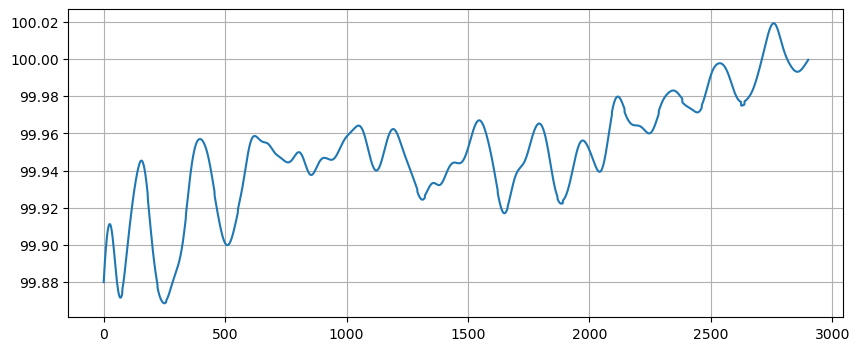

100%|██████████| 1/1 [00:08<00:00,  8.50s/it]


In [12]:
fs = noise_fs
f0 = 100
I = 1
epsilon = 1e-20
tau = int(2500)

denoised_signal = RFA(bandpass_sig, noise_fs, tau, epsilon, I, f0)

  0%|          | 0/1 [00:00<?, ?it/s]

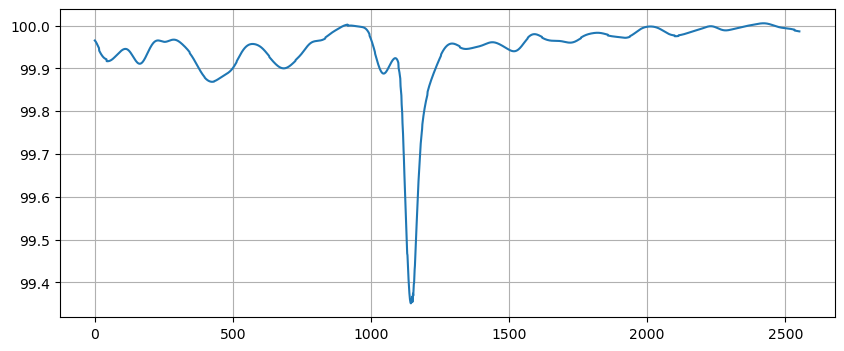

100%|██████████| 1/1 [00:05<00:00,  5.36s/it]


In [13]:
fs = noise_fs
f0 = 100
I = 1
epsilon = 1e-20
tau = int(2500)

cut_denoised_signal = RFA(bandpass_sig_cut, cut_noise_fs, tau, epsilon, I, f0)

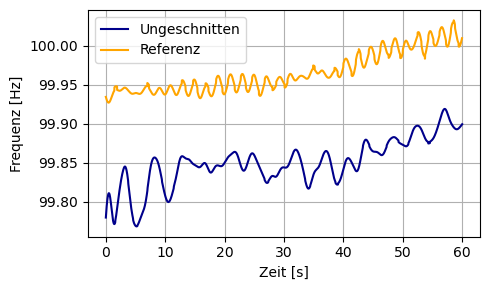

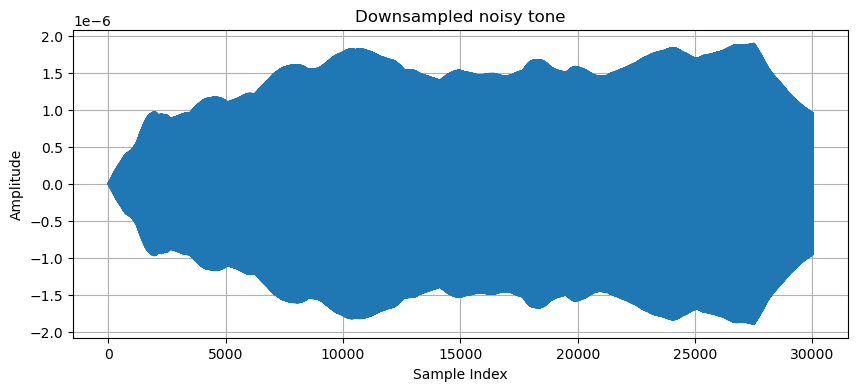

30016
30016


In [15]:
freqs_DFT1 = segmented_freq_estimation_DFT1(denoised_signal, noise_fs, 100, 20_000, 100)
freqs_ref = segmented_freq_estimation_DFT1(bandpass_ref, ref_fs, 100, 20_000, 100)

time_ref = np.linspace(0.0, x_ref, len(freqs_ref))
time = np.linspace(0.0, x, len(freqs_DFT1))

plt.figure(figsize=(5, 3))
plt.plot(time, freqs_DFT1-0.1, color="#00008B", label = "Ungeschnitten")
plt.plot(time_ref, freqs_ref, color="orange", label = "Referenz")
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('whu_authentic_freqs.pdf', dpi=300)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(denoised_signal)
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

print(len(denoised_signal))
print(len(bandpass_sig))

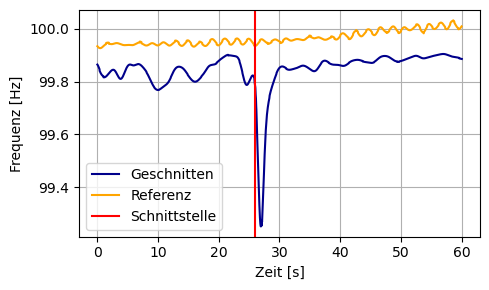

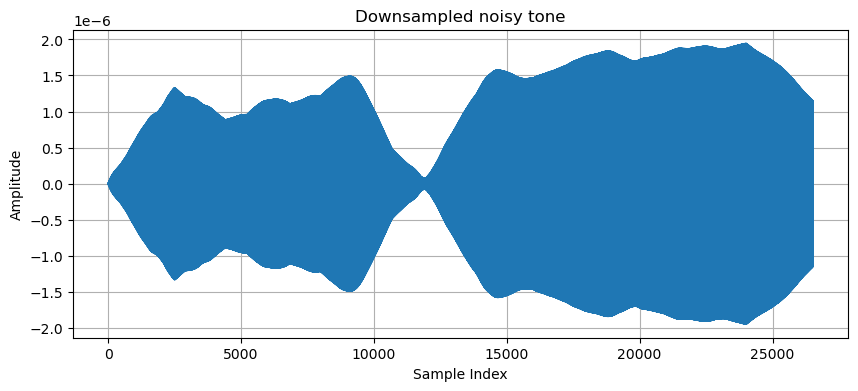

26516
26516


In [16]:
freqs_DFT1_cut = segmented_freq_estimation_DFT1(cut_denoised_signal, cut_noise_fs, 100, 20_000, 100)
freqs_ref = segmented_freq_estimation_DFT1(bandpass_ref, ref_fs, 100, 20_000, 100)

time_ref = np.linspace(0.0, x_ref, len(freqs_ref))
time_cut = np.linspace(0.0, x, len(freqs_DFT1_cut))
cut_start = 26

plt.figure(figsize=(5, 3))
plt.plot(time_cut, freqs_DFT1_cut-0.1, color="#00008B", label = "Geschnitten")
plt.plot(time_ref, freqs_ref, color="orange", label = "Referenz")
plt.axvline(cut_start, color="red", label = "Schnittstelle")
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('whu_tampered_freqs.pdf', dpi=300)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(cut_denoised_signal)
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

print(len(cut_denoised_signal))
print(len(bandpass_sig_cut))

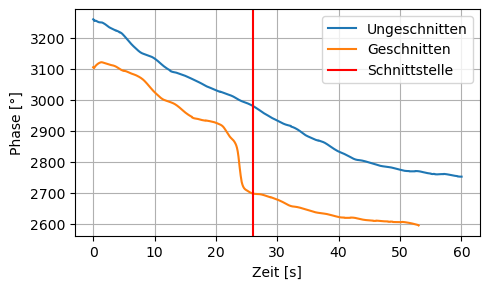

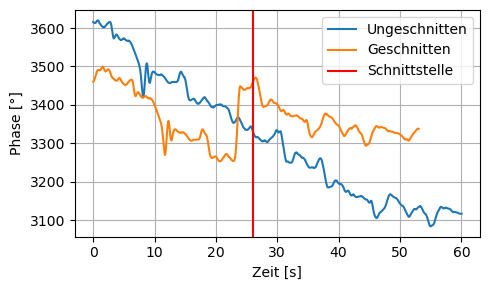

In [18]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_denoised = segmented_phase_estimation_hilbert(denoised_signal, fs, NUM_CYCLES, 50)
phases_denoised = np.unwrap(phases_denoised)
x = len(denoised_signal)/noise_fs

phases_denoised_cut = segmented_phase_estimation_hilbert(cut_denoised_signal, fs, NUM_CYCLES, 50)
phases_denoised_cut = np.unwrap(phases_denoised_cut)
x_cut = len(cut_denoised_signal)/noise_fs

time = np.linspace(0.0, 2*x, len(phases_denoised))
time_cut = np.linspace(0.0, 2*x_cut, len(phases_denoised_cut))
cut_start = 26

plt.figure(figsize=(5, 3))
plt.plot(time, np.degrees(phases_denoised), label = "Ungeschnitten")
plt.plot(time_cut, np.degrees(phases_denoised_cut)-150, label = "Geschnitten")
plt.axvline(cut_start, color="red", label = "Schnittstelle")
plt.xlabel("Zeit [s]")
plt.ylabel("Phase [°]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('whu_authentic_phases.pdf', dpi=300)
plt.show()

N_DFT = 20_000
NUM_CYCLES = 10

phases_denoised = segmented_phase_estimation_hilbert(bandpass_sig, fs, NUM_CYCLES, 50)
phases_denoised = np.unwrap(phases_denoised)
x = len(bandpass_sig)/noise_fs

phases_denoised_cut = segmented_phase_estimation_hilbert(bandpass_sig_cut, fs, NUM_CYCLES, 50)
phases_denoised_cut = np.unwrap(phases_denoised_cut)
x_cut = len(bandpass_sig_cut)/noise_fs

time = np.linspace(0.0, 2*x, len(phases_denoised))
time_cut = np.linspace(0.0, 2*x_cut, len(phases_denoised_cut))
cut_start = 26

plt.figure(figsize=(5, 3))
plt.plot(time, np.degrees(phases_denoised), label = "Ungeschnitten")
plt.plot(time_cut, np.degrees(phases_denoised_cut)-150, label = "Geschnitten")
plt.axvline(cut_start, color="red", label = "Schnittstelle")
plt.xlabel("Zeit [s]")
plt.ylabel("Phase [°]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('whu_tampered_phases.pdf', dpi=300)
plt.show()

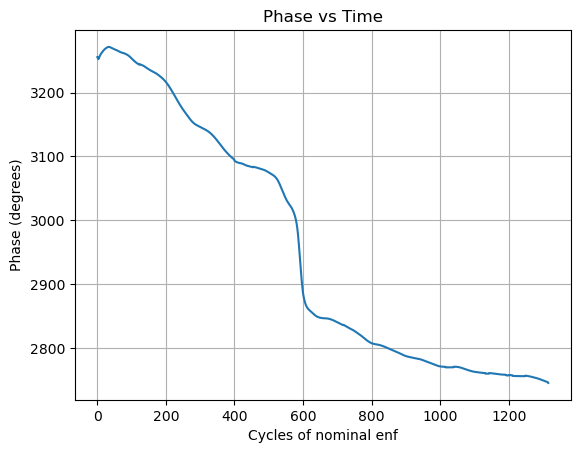

In [44]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_denoised_cut = segmented_phase_estimation_hilbert(cut_denoised_signal, fs, NUM_CYCLES, 50)
phases_denoised_cut = np.unwrap(phases_denoised_cut)

x_denoised_cut = np.arange(len(phases_denoised_cut))
plt.plot(x_denoised_cut, np.degrees(phases_denoised_cut))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

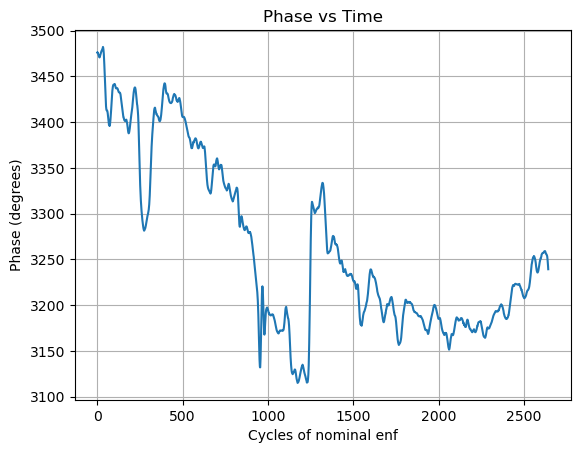

In [45]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_cut = segmented_phase_estimation_hilbert(bandpass_sig_cut, fs, NUM_CYCLES, 50)
phases_cut = np.unwrap(phases_cut)

x_cut = np.arange(len(phases_cut))
plt.plot(x_cut, np.degrees(phases_cut))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

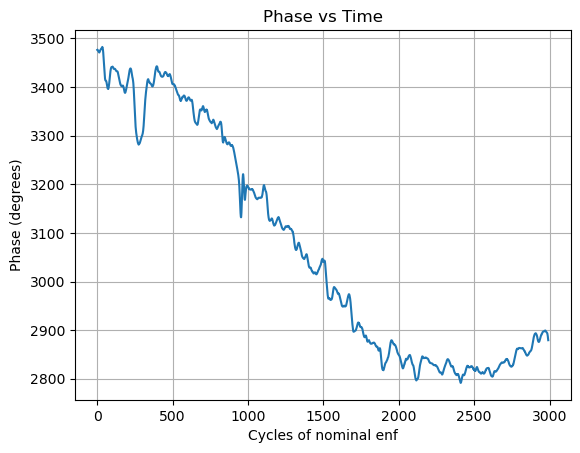

In [46]:
N_DFT = 20_000
NUM_CYCLES = 10

phases = segmented_phase_estimation_hilbert(bandpass_sig, fs, NUM_CYCLES, 50)
phases = np.unwrap(phases)

x = np.arange(len(phases))
plt.plot(x, np.degrees(phases))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

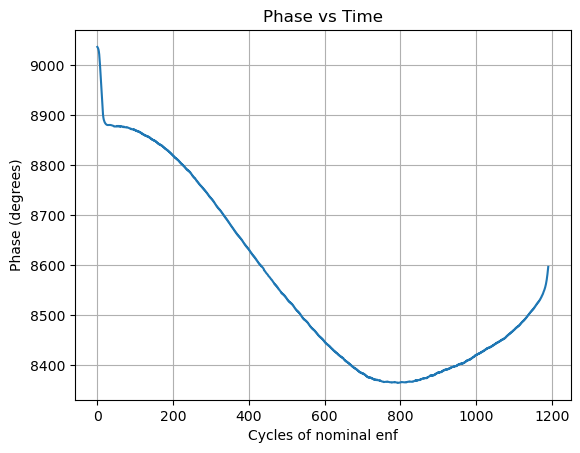

In [32]:
N_DFT = 20_000
NUM_CYCLES = 10

phases_ref = segmented_phase_estimation_hilbert(bandpass_ref, fs, NUM_CYCLES, 50)
phases_ref = np.unwrap(phases_ref)

x_ref = np.arange(len(phases_ref))
plt.plot(x_ref, np.degrees(phases_ref))
plt.xlabel("Cycles of nominal enf")
plt.ylabel("Phase (degrees)")
plt.title("Phase vs Time")
plt.grid(True)
plt.show()

In [16]:
def find_cut_in_phases(phases, x):
    """_summary_

    Args:
        phases (_type_): _description_
        x (_type_): _description_

    Returns:
        _type_: _description_
    """

    range_threshold = 20
    window_size = 10
    second_der = np.gradient(np.gradient(phases, x), x)

    plt.scatter(x, second_der, s=10)
    plt.xlabel("Cycles of nominal enf")
    plt.ylabel("second derivative")
    plt.title("Second derivative")
    plt.grid(True)
    plt.show()

    z_scores = np.abs(stats.zscore(second_der))
    outliers = np.array(np.where(z_scores > 5))

    plt.scatter(x, z_scores, s=10)
    plt.xlabel("Cycles of nominal enf")
    plt.ylabel("second derivative")
    plt.title("Second derivative")
    plt.grid(True)
    plt.show()

    if not np.any(outliers):
        return phases, x, outliers

    else:
        discontinuities = []
        i = 0

        while i < len(outliers[0]) - 1:
            start = outliers[0][i]
            while (
                i < len(outliers[0]) - 1
                and (outliers[0][i + 1] - outliers[0][i]) <= range_threshold
            ):
                i += 1
            end = outliers[0][i]

            # Search for the cut discontinuitites
            if end - start >= window_size:
                segment = second_der[start : end + 1]
                pos_count = np.sum(segment > 0)
                neg_count = np.sum(segment < 0)

                if pos_count > 0 and neg_count > 0:
                    discontinuities.append((start, end))

            i += 1

        discontinuities = np.array(discontinuities)

        if not np.any(discontinuities):
            return phases, x, discontinuities

        start = discontinuities[0][0]
        end = discontinuities[0][1]

        phases_new = phases[int(start) - 200 : int(end) + 200]
        x_new = x[int(start) - 200 : int(end) + 200]

        return phases_new, x_new, discontinuities

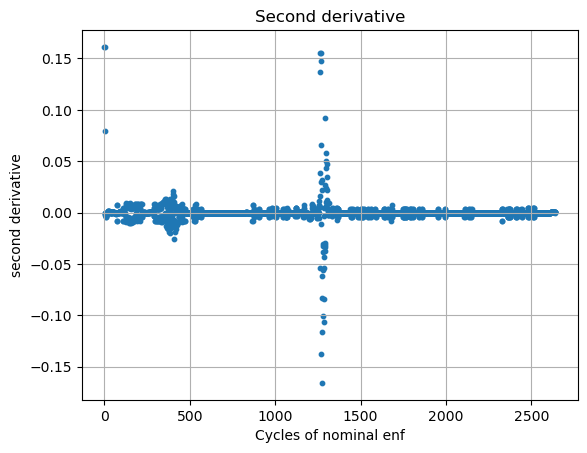

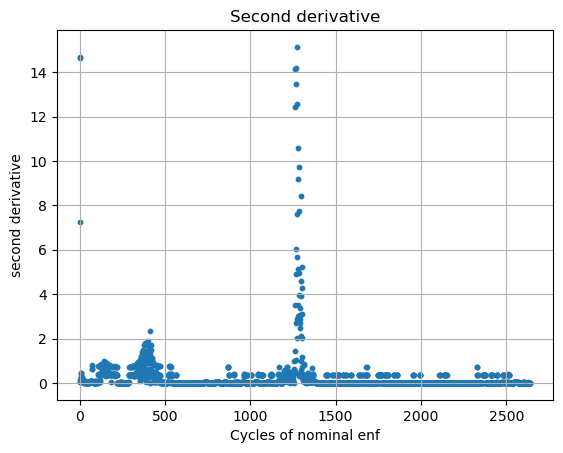

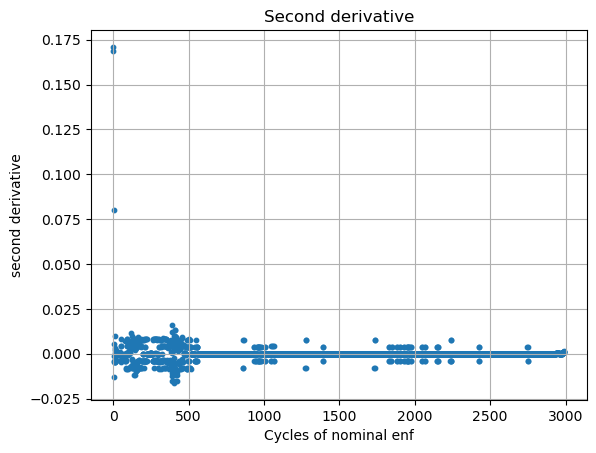

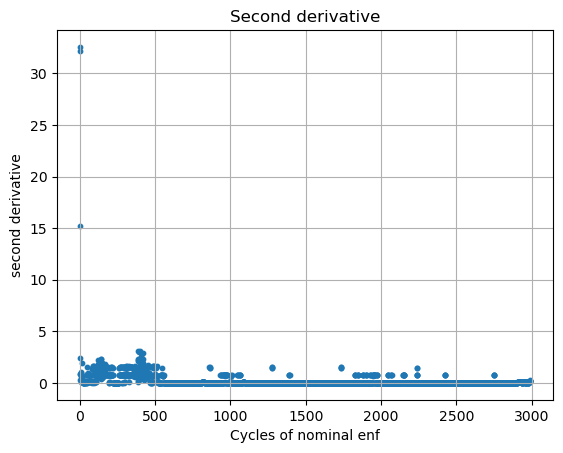

In [17]:
phases_cut, x_cut, cut_discontinuities = find_cut_in_phases(phases_denoised_cut, x_denoised_cut)
phases, x, discontinuities = find_cut_in_phases(phases_denoised, x_denoised)

In [18]:
import numpy as np
from scipy.io import wavfile
import os

from enfify.preprocessing import downsample_ffmpeg, bandpass_filter, extract_number, cut_extract_number
#from enfify.enf_enhancement import VMD, RFA

In [19]:
import numpy as np
import math
from enfify.enf_estimation import segmented_freq_estimation_DFT1
from tqdm import tqdm
from numba import jit, prange
from scipy.signal import get_window, windows
from scipy.fft import fft
import matplotlib.pyplot as plt

# ...........................RFA................................#

@jit(nopython=True, fastmath=True)
def z_SFM(sig, n, fs, alpha, tau):
    """Computes the z_SFM value with JIT optimization."""
    sum_sig = np.sum(sig[n - tau : n + tau + 1])
    z = np.exp(1j * 2 * np.pi * (1 / fs) * alpha * sum_sig)
    return z


@jit(nopython=True, parallel=True, fastmath=True)
def kernel_function(sig, f, n, fs, alpha, tau_values, tau_dash_values):
    """Computes the kernel function using JIT and vectorized operations."""
    auto_corr = np.empty(len(tau_values), dtype=np.complex128)
    auto_corr_dash = np.empty(len(tau_dash_values), dtype=np.complex128)

    for i in range(len(tau_values)):
        auto_corr[i] = z_SFM(sig, n, fs, alpha, tau_values[i])
        auto_corr_dash[i] = z_SFM(sig, n, fs, alpha, tau_dash_values[i])

    sin_vals = np.sin(2 * np.pi * (1 / fs) * f * tau_values)
    cos_vals = np.cos(2 * np.pi * (1 / fs) * f * tau_values)

    # Precompute exponents to save time in kernel calculation
    kernel = (auto_corr**sin_vals) * (auto_corr_dash**cos_vals)
    return np.angle(kernel)


@jit(nopython=True, parallel=True, fastmath=True)
def rfa_kernel_phases(sig, denoised_sig, Nx, f_start, fs, alpha, tau, tau_values, tau_dash_values):
    for n in prange(Nx - 1):
        f = f_start[n]
        kernel_phases = kernel_function(sig, f, n, fs, alpha, tau_values, tau_dash_values)
        denoised_sig[n] = np.sum(kernel_phases) / ((tau + 1) * tau * np.pi * alpha)

    return denoised_sig


def RFA(sig, fs, tau, epsilon, var_I, estimated_enf):
    """Optimized Recursive Frequency Adaptation algorithm with partial JIT optimization."""
    Nx = len(sig)
    alpha = 1 / (4 * fs * np.max(sig))
    f_start = estimated_enf * np.ones(Nx)
    tau_values = np.arange(1, tau + 1)
    tau_dash_values = tau_values + int(np.round(fs / (4 * estimated_enf)))

    for k in tqdm(range(var_I)):
        denoised_sig = np.zeros(Nx)

        denoised_sig = rfa_kernel_phases(
            sig, denoised_sig, Nx, f_start, fs, alpha, tau, tau_values, tau_dash_values
        )

        # Peak frequency estimation
        peak_freqs = segmented_freq_estimation_DFT1(
            denoised_sig, fs, num_cycles=10, N_DFT=20_000, nominal_enf=estimated_enf
        )

        '''
        plt.plot(peak_freqs)
        plt.xlabel("Cycles of nominal enf")
        plt.ylabel("Frequency Hz")
        plt.title("Frequency vs Time")
        plt.grid(True)
        plt.show()'''

        base_repeats = Nx // len(peak_freqs)
        remainder = Nx % len(peak_freqs)
        repeat_counts = np.full(len(peak_freqs), base_repeats)
        repeat_counts[:remainder] += 1
        new_freqs = np.repeat(peak_freqs, repeat_counts)

        f_diff = new_freqs - f_start
        f_start = new_freqs

        val = np.sum(f_diff**2) / np.sum(f_start**2)

        if val <= epsilon:
            return denoised_sig

        sig = denoised_sig  # Update the signal for the next iteration

    return denoised_sig

In [20]:
# ...................................Variational Mode Decomposition 2...................................#
def VMD_2(signal, alpha, tau, num_modes, enforce_DC, tolerance):
    """Variational Mode Decomposition (VMD)

    Args:
        signal (array): Input signal.
        alpha (float): Regularization parameter for the modes.
        tau (float): Time-step for dual ascent.
        num_modes (int): Number of modes to extract.
        enforce_DC (bool): Whether to enforce a DC component.
        tolerance (float): Convergence tolerance.

    Returns:
        modes (array): Decomposed modes.
        mode_spectra_final (array): Final mode spectra.
        final_freq_centers (array): Center frequencies of modes.
    """

    # Mirror signal at boundaries (optimized)
    signal_len = len(signal)
    midpoint = signal_len // 2
    if signal_len % 2:
        mirrored_signal = np.concatenate(
            [np.flipud(signal[:midpoint]), signal, np.flipud(signal[midpoint + 1 :])]
        )
    else:
        mirrored_signal = np.concatenate(
            [np.flipud(signal[:midpoint]), signal, np.flipud(signal[midpoint:])]
        )

    # Time and frequency domains
    total_length = len(mirrored_signal)
    time_domain = np.arange(total_length) / total_length
    spectral_domain = time_domain - 0.5

    # Precompute FFT of the mirrored signal
    signal_spectrum = np.fft.fftshift(np.fft.fft(mirrored_signal))
    positive_spectrum = np.zeros_like(signal_spectrum, dtype=complex)
    positive_spectrum[total_length // 2 :] = signal_spectrum[total_length // 2 :]

    # Mode and frequency center initialization
    max_iterations = 500
    mode_alphas = np.full(num_modes, alpha)
    freq_centers = np.zeros((max_iterations, num_modes))

    # Set initial frequency centers
    freq_centers[0, :] = 0.5 / num_modes * np.arange(num_modes)
    if enforce_DC:
        freq_centers[0, 0] = 0

    # Initialize dual variables and mode spectra
    dual_vars = np.zeros(total_length, dtype=complex)
    mode_spectra = np.zeros((max_iterations, total_length, num_modes), dtype=complex)

    # Iteration parameters
    convergence_criteria = tolerance + np.spacing(1)
    iteration_count = 0

    while convergence_criteria > tolerance and iteration_count < max_iterations - 1:
        mode_sum = np.sum(mode_spectra[iteration_count, :, :], axis=1)

        for mode in range(num_modes):
            residual = positive_spectrum - mode_sum + mode_spectra[iteration_count, :, mode]
            denom = (
                1
                + mode_alphas[mode] * (spectral_domain - freq_centers[iteration_count, mode]) ** 2
            )

            mode_spectra[iteration_count + 1, :, mode] = (residual - dual_vars / 2) / denom

            if mode == 0 and enforce_DC:
                freq_centers[iteration_count + 1, mode] = 0
            else:
                # Update frequency centers using the mode's positive frequencies
                mode_fft_half = mode_spectra[iteration_count + 1, total_length // 2 :, mode]
                freq_centers[iteration_count + 1, mode] = np.dot(
                    spectral_domain[total_length // 2 :], np.abs(mode_fft_half) ** 2
                ) / np.sum(np.abs(mode_fft_half) ** 2)

        # Dual ascent step
        dual_vars += tau * (
            np.sum(mode_spectra[iteration_count + 1, :, :], axis=1) - positive_spectrum
        )

        # Check for convergence
        convergence_criteria = np.linalg.norm(
            mode_spectra[iteration_count + 1, :, :] - mode_spectra[iteration_count, :, :],
            ord="fro",
        ) / np.linalg.norm(mode_spectra[iteration_count, :, :], ord="fro")
        iteration_count += 1

    # Extract the final results
    max_iterations = iteration_count
    final_freq_centers = freq_centers[:max_iterations, :]

    # Symmetrize the spectrum and reconstruct the signal modes
    final_mode_spectra = np.zeros((total_length, num_modes), dtype=complex)
    final_mode_spectra[total_length // 2 :, :] = mode_spectra[
        max_iterations - 1, total_length // 2 :, :
    ]

    # Handling even/odd length symmetry
    if total_length % 2 == 0:
        final_mode_spectra[:total_length // 2, :] = np.conj(final_mode_spectra[-1:total_length // 2-1:-1, :])
    else:
        final_mode_spectra[:total_length // 2, :] = np.conj(final_mode_spectra[-1:total_length // 2:-1, :])

    # Inverse FFT to obtain the modes
    modes = np.real(np.fft.ifft(np.fft.ifftshift(final_mode_spectra, axes=0), axis=0))

    # Trim the modes to the original signal length
    modes = modes[total_length // 4 : 3 * total_length // 4, :]

    # Compute the final spectra for the modes
    mode_spectra_final = np.fft.fftshift(np.fft.fft(modes, axis=0), axes=0)

    return modes.T, mode_spectra_final, final_freq_centers

In [46]:
from pathlib import Path
from glob import glob
import librosa

# Audio Paths
PATH = Path("/home/leo_dacasi/Dokumente/summerofcode/Enfify Data Synced/external/Carioca/BASE CARIOCA ALL")

# Get Cut and Uncut Files
filenames = sorted(glob(str(Path(PATH / "*.wav"))))

cut_files = [f for f in filenames if "e" in Path(f).name]
uncut_files = [f for f in filenames if "e" not in Path(f).name]

In [48]:
# Constants sig, lowcut, highcut, fs, order
DOWNSAMPLE_FS = 1200
BANDPASS_ORDER = 5
BNP_LOW = 59.3
BNP_HIGH = 60.3

ALPHA = 5000  # Balancing parameter of the data-fidelity constraint
TAU = 0  # Noise-tolerance (no strict fidelity enforcement)
N_MODE = 1  # Number of modes to be recovered
DC = 0
TOL = 1e-7  # Tolerance of convergence criterion

F0 = 60
I = 1
EPSILON = 1e-20
TAU_RFA = int(2000)

N_DFT = 20_000
NUM_CYCLES = 100

step_size = 0.02
window_size = 0.2

k = 1

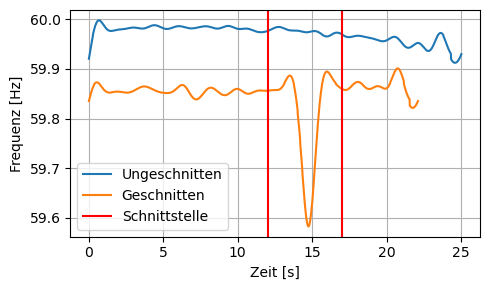

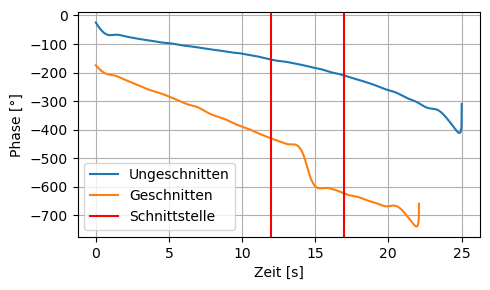

In [58]:
## ENF Preprocessing and enhancement
data_cut, sample_rate_cut = librosa.load(cut_files[0])
data, sample_rate = librosa.load(uncut_files[0])


# Downsampling
down_sig_cut, down_fs_cut = downsample_ffmpeg(data_cut, sample_rate_cut, DOWNSAMPLE_FS)
down_sig, down_fs = downsample_ffmpeg(data, sample_rate, DOWNSAMPLE_FS)

# Bandpass
band_sig_cut = bandpass_filter(down_sig_cut, BNP_LOW, BNP_HIGH, DOWNSAMPLE_FS, BANDPASS_ORDER)
band_sig = bandpass_filter(down_sig, BNP_LOW, BNP_HIGH, DOWNSAMPLE_FS, BANDPASS_ORDER)


freqs_cut = segmented_freq_estimation_DFT1(band_sig_cut, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)
freqs = segmented_freq_estimation_DFT1(band_sig, DOWNSAMPLE_FS, NUM_CYCLES, N_DFT, F0)

x = len(bandpass_sig)/down_fs
x_cut = len(bandpass_sig_cut)/down_fs_cut

time = np.linspace(0.0, x, len(freqs))
time_cut = np.linspace(0.0, x_cut, len(freqs_cut))
cut_start = 12

plt.figure(figsize=(5, 3))
plt.plot(time, freqs, label = "Ungeschnitten")
plt.plot(time_cut, freqs_cut-0.1, label = "Geschnitten")
plt.axvline(cut_start, color="red", label = "Schnittstelle")
plt.axvline(cut_start+5, color="red")
plt.xlabel("Zeit [s]")
plt.ylabel("Frequenz [Hz]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('carioca_freqs.pdf', dpi=300)
plt.show()

step_size = 0.02
window_len = 0.2

phases = segmented_phase_estimation_DFT1(band_sig, down_fs, 60, N_DFT, step_size, window_len)
phases = np.unwrap(phases)
x = len(bandpass_sig)/down_fs

phases_cut = segmented_phase_estimation_DFT1(band_sig_cut, down_fs, 60, N_DFT, step_size, window_len)
phases_cut = np.unwrap(phases_cut)
x_cut = len(bandpass_sig_cut)/down_fs_cut

time = np.linspace(0.0, x, len(phases))
time_cut = np.linspace(0.0, x_cut, len(phases_cut))


plt.figure(figsize=(5, 3))
plt.plot(time, np.degrees(phases), label = "Ungeschnitten")
plt.plot(time_cut, np.degrees(phases_cut)-100, label = "Geschnitten")
plt.axvline(cut_start, color="red", label = "Schnittstelle")
plt.axvline(cut_start+5, color="red")
plt.xlabel("Zeit [s]")
plt.ylabel("Phase [°]")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('carioca_phases.pdf', dpi=300)
plt.show()